# Introducción

En este análisis, nuestro objetivo principal es explorar las relaciones causales que podrían influir en la probabilidad de aprobar la primera evaluación del curso, utilizando la biblioteca DoWhy en Python. Previamente, se llevó a cabo un análisis de importancia de características utilizando SHAP, identificando varias características que parecen tener un impacto significativo. Ahora, con DoWhy, intentamos ir más allá del mero diagnóstico de importancia y explorar cómo estas características interactúan y posiblemente causan los cambios observados en la probabilidad de aprobación.

## Análisis de Características Principales con SHAP

Inicialmente, realizamos un análisis con SHAP para identificar las características más relevantes que afectan la probabilidad de aprobación. Según este análisis, las características más influyentes son:

- `hito1`
- `exitosos`
- `fallidos`
- `e42`
- `e3`
- `e35`
- `e29`
- `e18`

Estas características fueron identificadas como las más críticas en la prediccion SHAP con un 81%.

## Integración con Análisis de Causalidad DoWhy

Para profundizar nuestro entendimiento, integramos los insights obtenidos a través de SHAP con un análisis de causalidad utilizando DoWhy. Este análisis nos permite investigar cómo las características identificadas como importantes por SHAP influyen causalmente en la aprobación. A través de este análisis, buscamos responder preguntas cruciales como:

1. ¿Cómo la variación en `hito1` afecta directa e indirectamente la aprobación?
2. ¿Cómo los efectos causales identificados pueden influir en la estrategia de intervención para mejorar las tasas de aprobación?


In [19]:
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from IPython.core.display import Image, display
import dowhy.causal_estimators.linear_regression_estimator
import random
import numpy as np

# Estableciendo la semilla para el generador de números aleatorios de la biblioteca 'random' en Python.
# Esto asegura que los números aleatorios generados con la biblioteca 'random' serán reproducibles en cada ejecución.
random.seed(0)
np.random.seed(0)
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sys import path
import os

for dirname, _, filenames in os.walk("../../resources/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath("../../"))

from custom import functions

warnings.filterwarnings("ignore")

../../resources/allColProSol.xlsx
../../resources/dataset_a_2021.csv
../../resources/dataset_a_2021c2.csv
../../resources/dataset_a_2021v1.xlsx
../../resources/dataset_unab_ORIGINAL SIN P1.csv
../../resources/dataset_unab_P1.csv
../../resources/exitoFallidoEnviosProgramaSol.xlsx
../../resources/exitoFallidoProgramaSol.xlsx
../../resources/exitosoFallidosEnviosAllColProSol.xlsx
../../resources/exitosoFallidosEnviosAllColSol.xlsx
../../resources/exitososFallidosEnviosSol.xlsx
../../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../../resources/sinColCeroExitosoFallidosSol.xlsx
../../resources/v2_hitosExitoFalloColESol1.csv
../../resources/v2_hitosExitoFalloColESol1Prograna.csv
../../resources/v2_hitosExitoFalloSol1Programa.csv
../../resources/causalidad\causalidad.dot
../../resources/causalidad\causalidad.png
../../resources/causalidad\causalidad_e29.dot
../../resources/causalidad\graph_causal_model_e29.png
../../resources/causal

In [20]:
# Read and preview data
df = pd.read_csv(
    "../../resources/v2_hitosExitoFalloColESol1.csv",
    delimiter=";",
    skipinitialspace=True,
)

In [21]:
# creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df["aprobado"] = df.apply(lambda x: functions.set_in_aprobado_nota(x["sol1"]), axis=1)
# revisamos la existencia de la nueva columna.
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


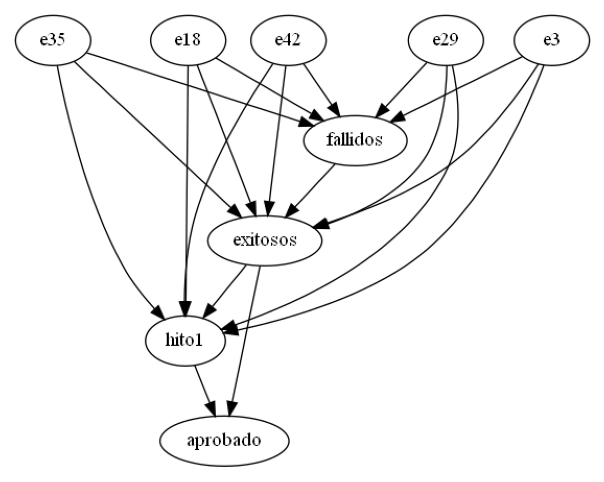

In [22]:
# Paso 1: Modelar un problema causal
model = CausalModel(
    data=df,
    treatment="hito1",  # Variable tratada (exposición)
    outcome="aprobado",  # Variable de resultado
    graph="""
        digraph {
            e42 -> exitosos;
            e42 -> fallidos;
            e42 -> hito1;
            e29 -> exitosos;
            e29 -> fallidos;
            e29 -> hito1;
            e3 -> exitosos;
            e3 -> fallidos;
            e3 -> hito1;
            e35 -> exitosos;
            e35 -> fallidos;
            e35 -> hito1;
            e18 -> exitosos;
            e18 -> fallidos;
            e18 -> hito1;
            hito1 -> aprobado;
            exitosos -> aprobado;
            fallidos -> exitosos;
            exitosos -> hito1;
        }
        """,
)
# Visualizar el modelo causal con la variable de causa común no observada
model.view_model(
    layout="dot",
    file_name="../../resources/causalidad/graph_causal_model_hito1",
)

In [23]:
# Paso 2: Identificar el estimando objetivo bajo el modelo
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[aprobado|exitosos])
d[hito₁]                      
Estimand assumption 1, Unconfoundedness: If U→{hito1} and U→aprobado then P(aprobado|hito1,exitosos,U) = P(aprobado|hito1,exitosos)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [24]:
# Paso 3: Estimar el efecto causal usando un método basado en árboles
estimate = model.estimate_effect(
    identified_estimand,
    test_significance=True,
    method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    target_units="ate",  # Average Treatment Effect
    method_params={
        "init_params": {
            "model_y": RandomForestRegressor(random_state=0),
            "model_t": RandomForestRegressor(random_state=0),
            "model_final": RandomForestRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=1502,
                n_estimators=500,
            ),
            "featurizer": None,
        },
        "fit_params": {},
    },
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(E[aprobado|exitosos])
d[hito₁]                      
Estimand assumption 1, Unconfoundedness: If U→{hito1} and U→aprobado then P(aprobado|hito1,exitosos,U) = P(aprobado|hito1,exitosos)

## Realized estimand
b: aprobado~hito1+exitosos | 
Target units: ate

## Estimate
Mean value: -0.20362315317793425
Effect estimates: [[-0.20362315]]
p-value: 0.111



In [25]:
# Refutador de datos aleatorios
refute1 = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
print(refute1)

Refute: Add a random common cause
Estimated effect:-0.20362315317793425
New effect:-0.11640820377631846
p value:0.56



In [26]:
# Refutador de causa común no observada
refute2 = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="binary_flip",
    effect_strength_on_treatment=0.01,
    effect_strength_on_outcome=0.02,
)
print(refute2)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.20362315317793425
New effect:0.17265953316553373



In [27]:
# Paso 4: Refutar el estimado obtenido
refute3 = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(refute3)

Refute: Use a Placebo Treatment
Estimated effect:-0.20362315317793425
New effect:0.01788451392154416
p value:0.96



### Conclusión

A través del análisis causal realizado, se investigó cómo la variable `hito1` podría influir en la probabilidad de aprobar la primera evaluación del curso. La estructura causal propuesta incluyó diversas variables asociadas con respuestas correctas e incorrectas en la guía, así como la relación entre `exitosos`, `fallidos` y `hito1` con la variable objetivo `aprobado`.

# Resultados Numéricos

Los modelos causales construidos proporcionaron las siguientes estimaciones del efecto causal y valores p para el tratamiento placebo:

1. **Estimación del Efecto Causal**:

   - Los modelos causales sugieren una asociación negativa entre `hito1` y la probabilidad de aprobar, aunque la estimación no es estadísticamente significativa (p-valor: 0.111).

2. **Resultados Numéricos**:

   - **Modelo hito1**:
     - Estimación del Efecto Causal: -0.20362315317793425
     - Refutación de Causa Común Aleatoria - Nuevo Efecto: -0.11640820377631846
     - Refutación de Causa Común No Observada - Nuevo Efecto: 0.17265953316553373
     - Tratamiento Placebo - Nuevo Efecto: 0.01788451392154416
     - Tratamiento Placebo - Valor p: 0.96

3. **Refutaciones**:

   - Las refutaciones indican una posible sensibilidad de la estimación del efecto causal a causas comunes no observadas y aleatorias, lo que sugiere la necesidad de explorar más a fondo las suposiciones del modelo.

4. **Tratamiento Placebo - Interpretación**:

   - El tratamiento placebo en el análisis introduce una variable de tratamiento ficticia para evaluar la robustez de las estimaciones del efecto causal. Los resultados de la refutación del tratamiento placebo indican que la estimación del efecto causal no es estadísticamente significativa.

5. **Interpretación del Valor p**:

   - Un valor p bajo (≤ 0.05) sugiere que los resultados son estadísticamente significativos y que es menos probable que sean producto del azar.
   - Un valor p alto (> 0.05) sugiere que los resultados no son estadísticamente significativos y que la relación observada podría ser producto del azar.
   - En este análisis, el valor p alto en el tratamiento placebo indica que las estimaciones del efecto causal no son estadísticamente significativas.

6. **Relevancia de `hito1`**:

   - La variable `hito1` mostró una asociación negativa con la probabilidad de aprobar, lo que sugiere que diferentes niveles de `hito1` podrían estar asociados con diferentes probabilidades de aprobar. Sin embargo, la falta de significancia estadística sugiere que se debe proceder con cautela en la interpretación de estos resultados.

7. **Implicaciones**:

   - Los resultados proporcionan una visión inicial sobre cómo `hito1` podría influir en la probabilidad de aprobar la primera evaluación del curso. Sin embargo, la interpretación de la relevancia y el impacto de `hito1` requiere una consideración cuidadosa de las suposiciones del modelo y posiblemente una exploración adicional mediante análisis de sensibilidad o recopilación de datos adicionales.

8. **Consideraciones Adicionales**:

   - También es crucial considerar la calidad y la cantidad de los datos, así como la adecuación de las suposiciones del modelo y la metodología de análisis.

Este análisis representa un paso inicial hacia la comprensión de las relaciones causales entre `hito1` y el rendimiento académico, y destaca la importancia de considerar las suposiciones del modelo y las variables confundidoras en la interpretación de los resultados.
